In [2]:
import os
import requests
from zipfile import ZipFile
from io import BytesIO

# 데이터셋 다운로드
dataset_url = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"
print("Downloading Caltech101 dataset...")
response = requests.get(dataset_url)

# 기존 디렉토리가 있다면 제거
if os.path.exists('caltech101'):
    import shutil
    shutil.rmtree('caltech101')

# 압축 해제
with ZipFile(BytesIO(response.content)) as z:
    z.extractall('caltech101')

# TMI) 디렉토리 구조 확인려고
print("\nContents of caltech101 directory:")
print(os.listdir('caltech101'))



Contents of caltech101 directory:
['__MACOSX', 'caltech-101']


In [3]:
# caltech-101 디렉토리 내부 확인
print("Contents of caltech-101 directory:")
print(os.listdir('caltech101/caltech-101'))

# 101_ObjectCategories 디렉토리가 있다면 그 내부도 확인
categories_path = 'caltech101/caltech-101/101_ObjectCategories'
if os.path.exists(categories_path):
    print("\nFirst few categories in 101_ObjectCategories:")
    categories = os.listdir(categories_path)
    print(f"Total number of categories: {len(categories)}")
    print("Sample categories:", categories[:5])


Contents of caltech-101 directory:
['show_annotation.m', '101_ObjectCategories.tar.gz', 'Annotations.tar']


In [4]:
import tarfile

# 101_ObjectCategories.tar.gz 압축 해제
categories_tar = 'caltech101/caltech-101/101_ObjectCategories.tar.gz'
with tarfile.open(categories_tar, 'r:gz') as tar:
    tar.extractall('caltech101/caltech-101/')

# 압축 해제 후 디렉토리 확인
print("\nAfter extraction - Contents of 101_ObjectCategories:")
categories_path = 'caltech101/caltech-101/101_ObjectCategories'
if os.path.exists(categories_path):
    categories = os.listdir(categories_path)
    print(f"Total number of categories: {len(categories)}")

    # 예시로 5개정도만
    print("Sample categories:", categories[:5])



After extraction - Contents of 101_ObjectCategories:
Total number of categories: 102
Sample categories: ['pyramid', 'cannon', 'ceiling_fan', 'hawksbill', 'bass']


In [5]:
# 샘플 카테고리의 내용 확인
sample_category = 'car_side'
sample_path = os.path.join(categories_path, sample_category)
print(f"\nContents of {sample_category} category:")
sample_images = os.listdir(sample_path)

# 이미지 개수랑, 이름 확인해보기
print(f"Number of images: {len(sample_images)}")
print("Sample image names:", sample_images[:5])

# 이미지 확장자 종류 확인
extensions = set()
for img_name in sample_images:
    ext = os.path.splitext(img_name)[1].lower()
    extensions.add(ext)
print("\nImage extensions found:", extensions)



Contents of car_side category:
Number of images: 123
Sample image names: ['image_0010.jpg', 'image_0067.jpg', 'image_0061.jpg', 'image_0026.jpg', 'image_0005.jpg']

Image extensions found: {'.jpg'}


# Dataset 클래스 구현

In [6]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np

class Caltech101Dataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = os.path.join(root_dir, 'caltech-101/101_ObjectCategories')
        self.transform = transform

        # BACKGROUND_Google 클래스 제외
        self.classes = [d for d in os.listdir(self.root_dir)
                       if os.path.isdir(os.path.join(self.root_dir, d))
                       and d != 'BACKGROUND_Google']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(class_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

        # 데이터 분할
        indices = list(range(len(self.images)))
        np.random.seed(42)
        np.random.shuffle(indices)
        split = int(0.8 * len(indices))

        if train:
            indices = indices[:split]
        else:
            indices = indices[split:]

        self.images = [self.images[i] for i in indices]
        self.labels = [self.labels[i] for i in indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터 변환 및 증강

In [7]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# 데이터로더 설정

In [8]:
from torch.utils.data import DataLoader

train_dataset = Caltech101Dataset('caltech101', transform=train_transform, train=True)
val_dataset = Caltech101Dataset('caltech101', transform=val_transform, train=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# ResNet18
(지난 실험에서 resnet50은 모델의 규모가 커서 한번의 학습에 시간이 너무 오래 걸렸던 경험이 있음. 여러 parameter 설정값을 통해 hyperparameter를 찾는 게 우선이라고 생각하여 자주 실험해보고자 이번에는 resnet18로 함)

In [9]:
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=101):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 2)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)
        self.layer4 = self.make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# SENet18
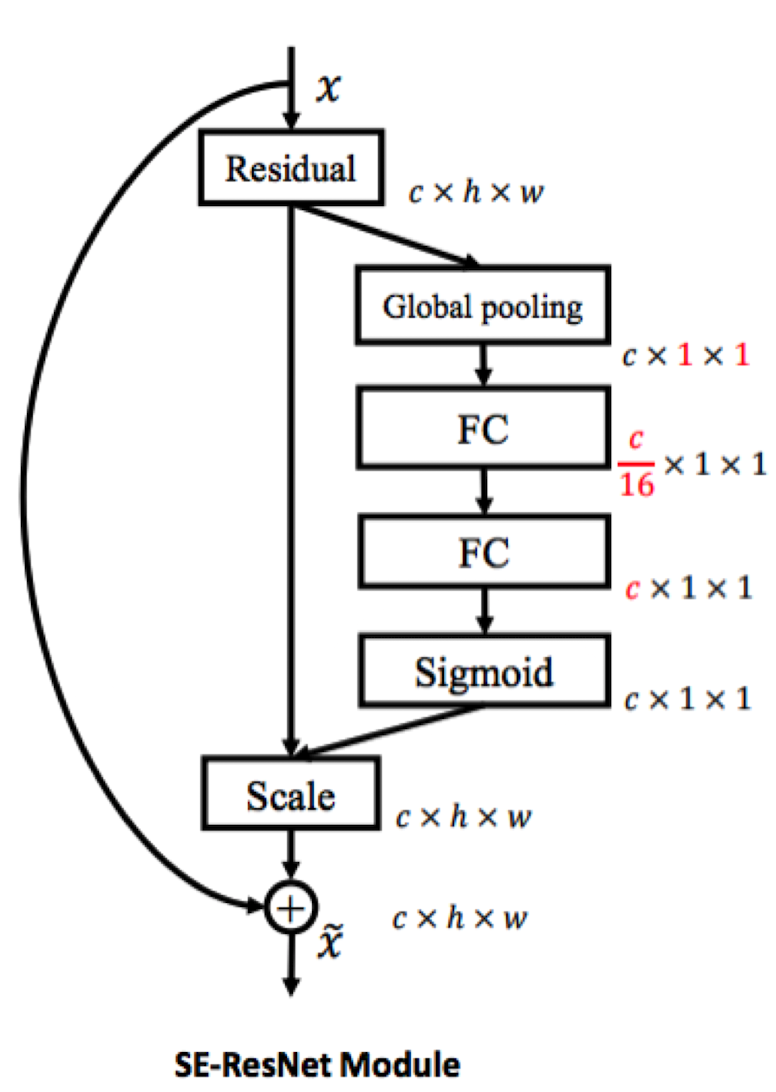

In [10]:
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class SENet18(nn.Module):
    def __init__(self, num_classes=101):
        super(SENet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 2)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)
        self.layer4 = self.make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(SEBasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(SEBasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# train, test, valid

In [11]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=30, patience=5):
    model = model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                break

    return train_losses, val_losses, train_accs, val_accs


# GPU 할당

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Resnet 학습

In [ ]:
resnet_model = ResNet18(num_classes=101).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-4)

# Validation Loss를 기준으로 학습률을 조정하는 ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

resnet_train_losses, resnet_val_losses, resnet_train_accs, resnet_val_accs = train_model(
    resnet_model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=30, patience=5
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30]
Train Loss: 3.9102, Train Acc: 20.01%
Val Loss: 4.7552, Val Acc: 18.32%
Epoch [2/30]
Train Loss: 3.3219, Train Acc: 28.54%
Val Loss: 3.1651, Val Acc: 29.84%
Epoch [3/30]
Train Loss: 2.9437, Train Acc: 35.36%
Val Loss: 2.7716, Val Acc: 37.73%
Epoch [4/30]
Train Loss: 2.6546, Train Acc: 40.41%
Val Loss: 2.6519, Val Acc: 39.98%
Epoch [5/30]
Train Loss: 2.4077, Train Acc: 43.71%
Val Loss: 2.2939, Val Acc: 45.62%
Epoch [6/30]
Train Loss: 2.2047, Train Acc: 47.67%
Val Loss: 2.3501, Val Acc: 46.31%
Epoch [7/30]
Train Loss: 2.0120, Train Acc: 51.35%
Val Loss: 1.9319, Val Acc: 52.42%
Epoch [8/30]
Train Loss: 1.8296, Train Acc: 54.75%
Val Loss: 1.7885, Val Acc: 55.76%
Epoch [9/30]
Train Loss: 1.7139, Train Acc: 56.76%
Val Loss: 1.6790, Val Acc: 58.76%
Epoch [10/30]
Train Loss: 1.5872, Train Acc: 59.08%
Val Loss: 1.6925, Val Acc: 58.35%
Epoch [11/30]
Train Loss: 1.4496, Train Acc: 62.76%
Val Loss: 1.4408, Val Acc: 64.06%
Epoch [12/30]
Train Loss: 1.3486, Train Acc: 63.95%
Val Loss: 1

# senet 학습

In [ ]:
senet_model = SENet18(num_classes=101).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(senet_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

senet_train_losses, senet_val_losses, senet_train_accs, senet_val_accs = train_model(
    senet_model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=30, patience=5
)

# plot 찍어보기

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(train_losses, val_losses, train_accs, val_accs, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss Curve")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, val_accs, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{model_name} - Accuracy Curve")
    plt.legend()

    plt.show()

# ResNet18 결과
plot_training_results(resnet_train_losses, resnet_val_losses, resnet_train_accs, resnet_val_accs, "ResNet18")

# SENet18 결과
plot_training_results(senet_train_losses, senet_val_losses, senet_train_accs, senet_val_accs, "SENet18")